In [1]:
import numpy as np
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
def generate_sequence(start, end_pos):
    seq = [start]
    pos = start
    while pos!=0 and pos!=end_pos:
        if np.random.rand()<0.5:
            pos = pos-1
        else:
            pos = pos+1
        seq.append(pos)
    return seq

In [3]:
def update(w, seq, alpha, lm):
    n_state = len(w)
    dw = np.zeros([n_state])
    et = np.zeros([n_state])

    for t in range(len(seq)-1):
        de = np.zeros([n_state])
        de[seq[t]] = 1
        et = de + lm * et
        
        P0 = w[seq[t]] 
        P1 = w[seq[t+1]]
#         if t < len(seq)-1:
#             P1 = w[seq[t+1]]
#         else:
#             P1 = 1 if seq[-1]==n_state-1 else 0
            
        #print(t, P1, P0, et)
        #print(P1-P0, sum(abs(et)))
        dw += alpha * (P1-P0) * et
        
    return dw

In [55]:
w_mean = np.array([0]*7)
N=1000
for _ in range(N):
    w = np.array([0,0.5,0.5,0.5,0.5,0.5,1])
    for _ in range(100):
        seq = generate_sequence(3, n_state-1)
        w += update(w, seq, 0.2, 0.3)
    w_mean = w_mean + w/N
w_mean

array([0.        , 0.16299431, 0.32665404, 0.49470966, 0.66253832,
       0.83093251, 1.        ])

In [35]:
n_state = 7
w_true = np.array([1/6.0, 1/3.0, 0.5, 2/3.0, 5/6.0])
training_size = 10
n_training_set = 100
lms = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
alphas = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
seqs = [[generate_sequence(3, n_state-1) for _ in range(training_size)] for _ in range(n_training_set)]

In [5]:
def rmse(w, w_true):
    return np.sqrt(np.mean((w-w_true)**2))

def training_1(alpha, lm, training_set):
    #w = np.ones([n_state])*0.5
    w = np.array([0,0.5,0.5,0.5,0.5,0.5,1])
    max_iteration = 10000

    seqs = []

    for n in range(max_iteration):
        dw = np.zeros([n_state])
        for seq in training_set:
            dw += update(w, seq, alpha/len(training_set), lm)
        w += dw
        #print(sum(abs(dw)), w, "\n")
        if sum(abs(dw)) < 1e-4:
            #print(f"converge in {n} iteration")
            break
    #w, sum(abs(dw))
    else:
        raise AssertionError("unconverged")
    error = rmse(w[1:-1], w_true)
    
    return error

def training_2(alpha, lm, training_set):
    #w = np.ones([n_state])*0.5
    w = np.array([0,0.5,0.5,0.5,0.5,0.5,1])
    for seq in training_set:
        w += update(w, seq, alpha, lm)
    error = rmse(w[1:-1], w_true)
    
    return error

def experiment_1(alpha, lm):
    errors = [training_1(alpha, lm, training_set) for training_set in tqdm(seqs)]
    return np.mean(errors), np.std(errors)

def experiment_2(alpha, lm):
    errors = [training_2(alpha, lm, training_set) for training_set in seqs]
    return np.mean(errors), np.std(errors)

In [6]:
pool = mp.Pool(mp.cpu_count())

errors = [pool.apply_async(experiment_1, args=(0.1, lm)) for lm in lms]
res = {lm: e.get()[0] for lm, e in zip(lms, errors)}

100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


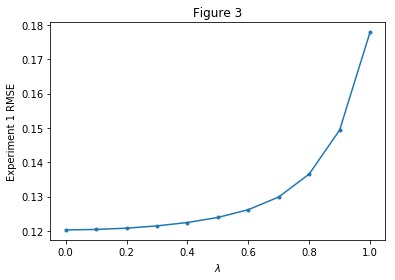

In [18]:
plt.plot(res.keys(), res.values(), marker='.')
plt.xlabel("$\lambda$")
plt.ylabel("Experiment 1 RMSE")
plt.title("Figure 3")
plt.show()

In [36]:
initial_error = rmse(np.array([0.5]*5), w_true)

errors = {}
for lm in lms:
    errors[lm] = {0: initial_error}
    for alpha in alphas:
        errors[lm][alpha], std = experiment_2(alpha, lm)

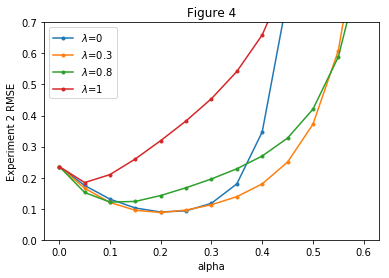

In [37]:
for lm in [0,0.3,0.8,1]:
    plt.plot(errors[lm].keys(), errors[lm].values(), label=f'$\lambda$={lm}', marker='.')
plt.legend()
plt.ylim(0,0.7)
plt.xlabel("alpha")
plt.ylabel("Experiment 2 RMSE")
plt.title("Figure 4")
plt.show()

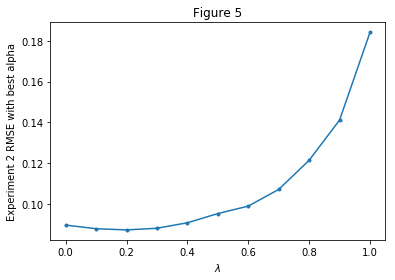

In [38]:
best_error = {lm: min(errors[lm].values()) for lm in errors}
    
plt.plot(best_error.keys(), best_error.values(), marker='.')
plt.xlabel("$\lambda$")
plt.ylabel("Experiment 2 RMSE with best alpha")
plt.title("Figure 5")
plt.show()